## Linear Regression

### Formel von David

In [113]:
import numpy as np
import hnumpy as hnp
import matplotlib.pyplot as plt

In [114]:
N = 32
X = np.linspace(0,1,N)

In [115]:
def getY(X):
    return 0.2 + X * 0.42 + np.random.uniform(-0.05, 0.05, len(X))

### Formel bisher (mean)

In [116]:
def lr_k(y):
    return np.sum(np.multiply(X-np.mean(X),y-np.mean(y))) / np.sum((X-np.mean(X))**2)

def lr_d(y):
    return np.mean(y) - np.sum(np.multiply(X-np.mean(X),y-np.mean(y))) / np.sum((X-np.mean(X))**2) * np.mean(X)

he_k = hnp.compile_fhe(
    lr_k,
    { "y": hnp.encrypted_ndarray(bounds=(0,1), shape=(N,)) }
)

he_d = hnp.compile_fhe(
    lr_d,
    { "y": hnp.encrypted_ndarray(bounds=(0,1), shape=(N,)) }
)

2022-01-17 13:45:41.761 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k into an FHE function
2022-01-17 13:45:41.762 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:45:41.763 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:45:41.765 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:45:41.793 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:45:41.794 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:45:41.795 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:45:41.796 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_d into an FHE function
2022-01-17 13:45:41.797 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:45:41.799 | INFO     | hnumpy.convert:compile_homomorphic:

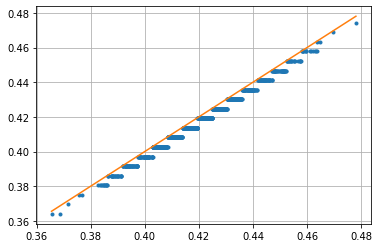

In [117]:
expected = []
simulate = []

rounds = 1000
for _ in range(rounds):
    y  = getY(X)
    _k = lr_k(y)
    k  = he_k.simulate(y)
    
    expected.append(_k)
    simulate.append(k)
    
plt.plot(expected,simulate,"o",markersize=3)
_x = np.linspace(min(expected),max(expected),100)
plt.plot(_x,_x)
plt.grid()
plt.show()

## David Formel

In [121]:
# y = ax + b

In [122]:
def lr_k_david(y):
    d = N * np.dot(X,X) - np.sum(X)**2
    alpha_i = np.array([N*xi-np.sum(X) for xi in X]) / d
    
    a = np.sum(alpha_i * y)
    
    return a

he_k_david = hnp.compile_fhe(
    lr_k_david,
    { "y": hnp.encrypted_ndarray(bounds=(0,1), shape=(N,)) }
)

2022-01-17 13:54:14.517 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_david into an FHE function
2022-01-17 13:54:14.520 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:54:14.522 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:54:14.524 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:54:14.536 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:54:14.537 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:54:14.538 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller


In [123]:
def lr_k_david_extra(y,z):
    d = N * np.dot(X,X) - np.sum(X)**2
    alpha_i = np.array([N*xi-np.sum(X) for xi in X]) / d
    
    alpha_enc = np.multiply(z,alpha_i)
    
    a = np.dot(alpha_enc, y)
    
    return (alpha_enc, a)

he_k_david_extra = hnp.compile_fhe(
    lr_k_david_extra,
    { "y": hnp.encrypted_ndarray(bounds=(0,1), shape=(N,)),
      "z": hnp.encrypted_ndarray(bounds=(0,1), shape=(N,))}
)

2022-01-17 13:54:14.765 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_david_extra into an FHE function
2022-01-17 13:54:14.767 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:54:14.771 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:54:14.773 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:54:14.790 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:54:14.791 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:54:14.793 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller


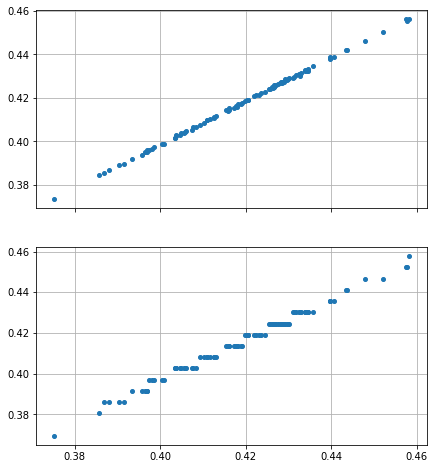

In [128]:
def getY(x):
    return 0.2 + X * 0.42 + np.random.uniform(-0.05, 0.05, len(X))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7,8))

X = np.linspace(0,1,N)
Z = np.ones(N)
N = 32
rounds = 100
for _ in range(rounds):

    y = getY(X)

    exp_alpha, exp_a = lr_k_david_extra(y,Z)
    
    alphas_x, a_x = he_k_david_extra.simulate(y,Z)
    
    a = he_k_david.simulate(y,Z)
    
    
    ax1.plot(exp_a, a_x, "o", c='C0', markersize=4)
    ax2.plot(exp_a, a, "o", c='C0', markersize=4)

ax1.grid()
ax2.grid()
plt.show()

# he_lrdd2.draw_intermediate_graph()

# he_lrdd2.draw_target_graph()

# he_lrdd2.export_compilation_report()


In [31]:
X = np.linspace(0,1,N)
y = getY(X)

print(linreg(y)[0])
print(linreg_dd(y))

0.3994785804633702
0.39947858046337026


2022-01-17 13:57:01.124 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:01.126 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:01.127 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:01.129 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:01.139 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:01.140 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:01.141 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:01.169 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:01.170 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:01.171 | INFO     | hnumpy.convert:compile_homomo

2022-01-17 13:57:01.350 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:01.352 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:01.360 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:01.362 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:01.364 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:01.366 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:01.367 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:01.369 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:01.371 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:01.381 | INFO     | hnumpy.co

2022-01-17 13:57:01.651 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:01.652 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:01.653 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:01.656 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:01.656 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:01.658 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:01.659 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:01.668 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:01.670 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:01.671 | INFO     | hnumpy.convert:compile_homomorphic:306 - Retu

2022-01-17 13:57:01.849 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:01.852 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:01.852 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:01.854 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:01.855 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:01.865 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:01.866 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:01.867 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:01.870 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:01.871 | INFO     | hnumpy.convert:

2022-01-17 13:57:02.051 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.052 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.053 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.064 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:02.065 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:02.067 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:02.070 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:02.072 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.072 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.073 | INFO     | hnumpy.convert:compile_homomorphic:270 -

2022-01-17 13:57:02.250 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.258 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:02.261 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:02.262 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:02.264 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:02.265 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.266 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.268 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.277 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:02.280 | INFO     | hnumpy.conve

2022-01-17 13:57:02.455 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:02.456 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:02.458 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:02.459 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.460 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.462 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.472 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:02.472 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:02.473 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:02.475 | INFO     | hnumpy.convert:compile_fhe:381

2022-01-17 13:57:02.655 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:02.656 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.657 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.658 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.667 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:02.669 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:02.670 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:02.673 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:02.674 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.675 | INFO     | hnumpy.convert:compile_homomo

2022-01-17 13:57:02.855 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.856 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.867 | INFO     | hnumpy.convert:compile_homomorphic:284 - Correct encoding
2022-01-17 13:57:02.868 | INFO     | hnumpy.convert:compile_homomorphic:290 - Create VM graph
2022-01-17 13:57:02.869 | INFO     | hnumpy.convert:compile_homomorphic:306 - Return the result to the caller
2022-01-17 13:57:02.872 | INFO     | hnumpy.convert:compile_fhe:381 - Compiling lr_k_dd into an FHE function
2022-01-17 13:57:02.873 | INFO     | hnumpy.convert:compile_fhe:383 - Checking input and output
2022-01-17 13:57:02.875 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2022-01-17 13:57:02.876 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `heuristic`
2022-01-17 13:57:02.885 | INFO     | hnumpy.co

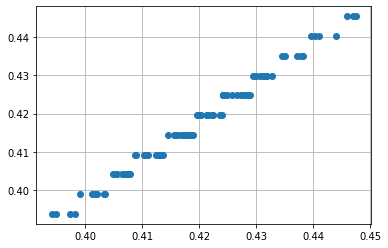

In [129]:
N = 16

def getY(X):
    return 0.2 + X * 0.42 + np.random.uniform(-0.025, 0.025, len(X))

expected = []
simulate = []

rounds = 100
for r in range(rounds):
    X = np.linspace(0,1,N)
    y = getY(X)
    
    def lr_k_dd(y):
        d = N * np.dot(X,X) - np.sum(X)**2
        alpha_i = np.array([N*xi-np.sum(X) for xi in X]) / d

        a = np.sum(alpha_i * y)

        return a

    he_k_dd = hnp.compile_fhe(
        lr_k_dd,
        { "y": hnp.encrypted_ndarray(bounds=(0,1), shape=(N,)) }
    )
    
    exp_res = lr_k_dd(y)
    sim_res = he_k_dd.simulate(y)
    
    plt.plot(exp_res, sim_res, "o", c='C0')
    
#     expected.append(exp_res)
#     simulate.append(sim_res)
    
# plt.plot(expected,simulate, "o", markersize=2)
# _x = np.linspace(min(expected),max(expected),100)
# plt.plot(_x,_x)
plt.grid()
plt.show()


In [ ]:
he_lrdd.draw_intermediate_graph()

he_lrdd.draw_target_graph()

### Full LR (David Formula)

In [32]:
def getY(x):
    return 0.2 + X * 0.42 + np.random.uniform(-0.05, 0.05, len(X))

N = 32
X = np.linspace(0,1,N)
Y = getY(X)
def linreg_dd(y):
    d = N * np.dot(X,X) - np.sum(x)**2
    alpha_i = np.array([N*xi-np.sum(X) for xi in X]) / d
    beta_i  = np.array([xi**2 - xi*np.sum(X) for xi in X]) / d
    
    a = np.dot(alpha_i, y)
    b = np.dot(beta_i, y)
    
    return (a,b)